In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from matplotlib.pyplot import figure
pd.options.mode.chained_assignment = None


## Load existing dataset

In [2]:
# each tract's census info, along with all years' cum store months
df_final = pd.read_csv('data_for_DID.csv')

In [3]:
df_final

,Unnamed: 0,tract,year,rec,med,dispensary_status,match_id,population,income,house_value,rent,unemployment,poverty
0,0,8001007801,2014,0.0,0.0,0.0,180.0,4149.0,12675.0,156800.0,647.0,0.12,0.58
1,1,8001007801,2015,12.0,0.0,0.0,180.0,3930.0,12526.0,165800.0,665.0,0.07,0.56
2,2,8001007801,2016,24.0,0.0,0.0,180.0,4374.0,15885.0,162100.0,742.0,0.08,0.47
3,3,8001007801,2017,36.0,0.0,0.0,180.0,4412.0,17653.0,174300.0,818.0,0.10,0.44
4,4,8001007801,2018,48.0,0.0,0.0,180.0,4137.0,21320.0,208200.0,920.0,0.06,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5803,5803,8125963200,2017,0.0,0.0,0.0,322.0,5467.0,25463.0,151600.0,739.0,0.02,0.13
5804,5804,8125963200,2018,0.0,0.0,0.0,322.0,5713.0,26952.0,201500.0,840.0,0.02,0.15
5805,5805,8125963200,2019,0.0,0.0,0.0,322.0,5581.0,29879.0,205500.0,892.0,0.03,0.13
5806,5806,8125963200,2020,0.0,0.0,0.0,322.0,5827.0,32704.0,201900.0,878.0,0.04,0.10


## Data Preparation & Linear Regression Model

In [4]:
def last_year_val(year, tract, df, outcome):
    if year ==2014:
        return 0
    else:
        curr_df = df[(df['year']==year-1)&(df['tract']==tract)]
        return curr_df[outcome].values[0]

In [9]:
df_all = []
df_stats = pd.DataFrame(columns=['Outcome', 'Coefficient', 'P-value'])
outcomes = ['income', 'population', 'house_value', 'rent', 'unemployment', 'poverty']
for i in range(6):
    outcome = outcomes[i]
    print('--- --- --- --- --- --- --- --- --- --- --- ---')
    print(outcome)
    print('--- --- --- --- --- --- --- --- --- --- --- ---')
    df = df_final[['tract', 'year', 'rec', 'med', outcome]]
    df['total'] = df['rec'] + df['med']
    df['last_year'] = df.apply(lambda x: last_year_val(x['year'], x['tract'], df, outcome), axis=1)
    df['difference'] = df[outcome] - df['last_year']
    
    """
    print()
    print('Box Plot (original data)')
    sns.boxplot(x=df[outcome])
    plt.show()
    """
    
    # remove outliers 
    Q1 = df[outcome].quantile(0.25)
    Q3 = df[outcome].quantile(0.75)
    IQR = Q3 - Q1
    Lower = Q1 - (1.5 * IQR)
    Upper = Q3 + (1.5 * IQR)
    df_valid = df[(df[outcome]<=Upper)&(df[outcome]>=Lower)&(df[outcome]!=2014)]
    
    """
    print('Box Plot (outliers removed)')
    sns.boxplot(x=df_valid[outcome])
    plt.show()
    """
    
    df_all.append(df_valid)
    
    #prepare data
    X = df_valid[['total', 'last_year']]
    y = df_valid[[outcome]]

    # scale the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    #fit LR model
    lr = LinearRegression().fit(X,y)

    # print coefficient and intercept
    print('Coefficient: ', lr.coef_)
    print('Intercept: ', lr.intercept_)

    # get p value
    mod = sm.OLS(y,X)
    fii = mod.fit()
    p_values = fii.summary2().tables[1]['P>|t|']
    print('p-values: ', p_values)
    print()
    
    # store values 
    row_to_append = pd.DataFrame([{'Outcome':outcome, 'Coefficient':lr.coef_[0][0], 'P-value':p_values[0]}])
    df_stats = pd.concat([df_stats, row_to_append])


--- --- --- --- --- --- --- --- --- --- --- ---
income
--- --- --- --- --- --- --- --- --- --- --- ---
Coefficient:  [[-902.16062683 7571.20584981]]
Intercept:  [33433.10403098]
p-values:  x1    5.040534e-02
x2    2.983221e-59
Name: P>|t|, dtype: float64

--- --- --- --- --- --- --- --- --- --- --- ---
population
--- --- --- --- --- --- --- --- --- --- --- ---
Coefficient:  [[-96.77945099 938.00447543]]
Intercept:  [3394.82521739]
p-values:  x1    4.066840e-02
x2    8.228189e-85
Name: P>|t|, dtype: float64

--- --- --- --- --- --- --- --- --- --- --- ---
house_value
--- --- --- --- --- --- --- --- --- --- --- ---
Coefficient:  [[ 3299.61972652 -5070.09986454]]
Intercept:  [312165.78255304]
p-values:  x1    0.488455
x2    0.287123
Name: P>|t|, dtype: float64

--- --- --- --- --- --- --- --- --- --- --- ---
rent
--- --- --- --- --- --- --- --- --- --- --- ---
Coefficient:  [[-17.64654923  -7.87821514]]
Intercept:  [1168.36648551]
p-values:  x1    0.286598
x2    0.634247
Name: P>|t|, dtyp

In [17]:
df_stats

,Outcome,Coefficient,P-value
0,income,-902.160627,0.050405
0,population,-96.779451,0.040668
0,house_value,3299.619727,0.488455
0,rent,-17.646549,0.286598
0,unemployment,-0.002901,0.000498
0,poverty,-0.004495,0.018844


In [12]:
df_stats.to_csv('Linear Regression Results.csv', index=False)

#### Scatter plots 

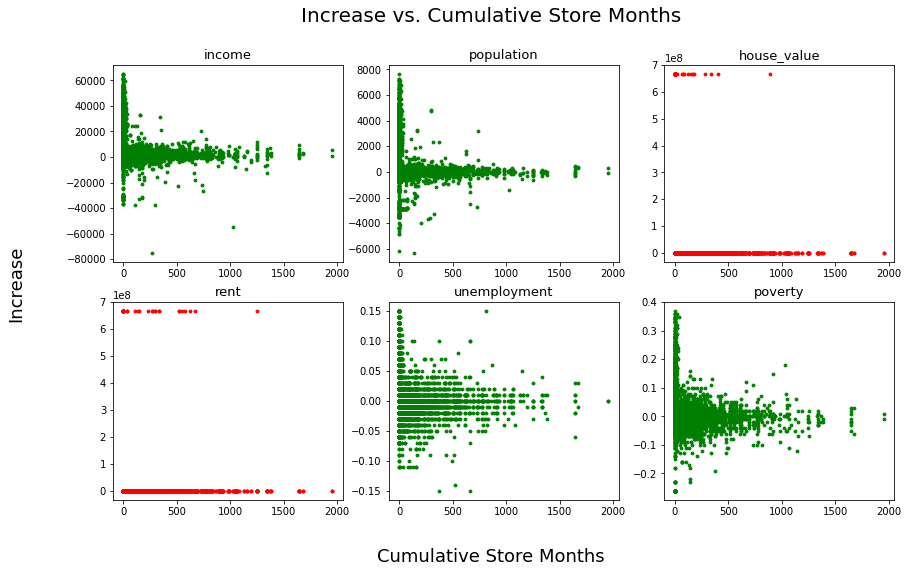

In [16]:
#figure(figsize=(8, 6), dpi=80)
fig, axs = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(14, 8, forward=True)

#add title
fig.suptitle('Increase vs. Cumulative Store Months', size=20)
fig.supxlabel('Cumulative Store Months', size=18)
fig.supylabel('Increase', size=18)

#add data to plots
axs[0, 0].scatter(df_all[0].total, df_all[0].difference, s=8, c='green')
axs[0, 0].set_title(outcomes[0], fontsize=13, loc='center')
axs[0, 1].scatter(df_all[1].total, df_all[1].difference, s=8, c='green')
axs[0, 1].set_title(outcomes[1], fontsize=13, loc='center')
axs[0, 2].scatter(df_all[2].total, df_all[2].difference, s=8, c='red')
axs[0, 2].set_title(outcomes[2], fontsize=13, loc='center')
axs[1, 0].scatter(df_all[3].total, df_all[3].difference, s=8, c='red')
axs[1, 0].set_title(outcomes[3], fontsize=13, loc='center')
axs[1, 1].scatter(df_all[4].total, df_all[4].difference, s=8, c='green')
axs[1, 1].set_title(outcomes[4], fontsize=13, loc='center')
axs[1, 2].scatter(df_all[5].total, df_all[5].difference, s=8, c='green')
axs[1, 2].set_title(outcomes[5], fontsize=13, loc='center')

plt.savefig('Scatter Plot.png', facecolor ="white")
plt.show()